# Contextual Multi-Arm Bandit
---

## Load Liblareis

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

## Generate Sample Data

In [2]:
def generate_sample_data(sample_num=10000):
    weight = np.array([
        [0.05, 0.05, -0.05],
        [-0.05, 0.05, 0.05],
        [0.05, -0.05, 0.05],
    ])

    arm_num = weight.shape[0]
    feature_wight = weight

    feature_vector = np.random.rand(sample_num, feature_wight.shape[0])
    theta = np.dot(feature_vector, feature_wight)
    is_cv = (theta > np.random.rand(sample_num, arm_num)).astype(np.int8)

    return feature_vector, is_cv, weight

## Parameter Tuning of Base Model

In [3]:
f_vector, is_cv, weight = generate_sample_data()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = f_vector
y = is_cv[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


for i in range(-1, 5):
    model = LogisticRegression(penalty='l2', C=10**i, max_iter=100, solver='lbfgs')
    model.fit(X_train, y_train)

    pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    print ('C={0} is {1}'.format(10**i, metrics.auc(fpr, tpr)))

C=0.1 is 0.7090395251999205
C=1 is 0.7089005624758634
C=10 is 0.7087939166643775
C=100 is 0.7087955325100062
C=1000 is 0.7087971483556347
C=10000 is 0.7087971483556347


## Train Model

In [ ]:
# %%debug
%load_ext autoreload
%autoreload
from contextual_bandit import ContextualBandit

seed = 42
np.random.seed(seed)

f_vector, rewords, weight = generate_sample_data(sample_num=100000)

n_arm = rewords.shape[1]
bandit_model = ContextualBandit(n_arm, n_estimator=10)

batch_size = 1000
lr_step = 5000

random_rewords = []
predict_rewords = []

pred_arm_history = np.array([]).astype(int)
rand_arm_history = np.array([]).astype(int)

for i in tqdm(range(0, f_vector.shape[0], batch_size)):
    start = i
    end = start + batch_size
    # バッチデータの切り取り
    X_batch = f_vector[start:end]
    y_batch = rewords[start:end]
    
    
    # ランダム選択の挙動
    ## アームの選択
    ## 過去すべてのアーム選択リストに追加
    ## 報酬の計算
    random_chosen_arms = np.random.randint(n_arm, size=batch_size)
    rand_arm_history = np.append(rand_arm_history, random_chosen_arms)
    random_rewords.append( rewords[:end][np.arange(rand_arm_history.shape[0]), rand_arm_history].mean() )
    
    # ----------------------------------------------------------------------------------------------------------------
    
    # バンディットの挙動
    ## 初期処理
    ## アームを選ぶ（予測をする）
    ## 過去すべてのアーム選択リストに追加
    ## 報酬の計算
    ## 過去すべてのアーム選択リストを元に得られた報酬を取得し、モデルを再学習
    ### 再学習はバッチごとに行う。partial_fitも存在する
    
    if i == 0:
        # 初期処理
        chosen_arms = np.random.randint(n_arm, size=batch_size)
        pred_arm_history = np.append(pred_arm_history, chosen_arms)
        pred_arm_rewords = rewords[np.arange(chosen_arms.shape[0]), chosen_arms]
        bandit_model.fit(f_vector[:end], pred_arm_history, pred_arm_rewords)
    else:
        chosen_arms = bandit_model.predict(X_batch)
        pred_arm_history = np.append(pred_arm_history, chosen_arms)
        pred_arm_rewords = rewords[np.arange(pred_arm_history.shape[0]), pred_arm_history]
        
        if i % lr_step == batch_size:
            bandit_model.fit(f_vector[:end], pred_arm_history, pred_arm_rewords)
        else:
            # partial_fit を追記する。
            pass
    
    predict_rewords.append(rewords[:end][np.arange(pred_arm_history.shape[0]), pred_arm_history].mean())
    

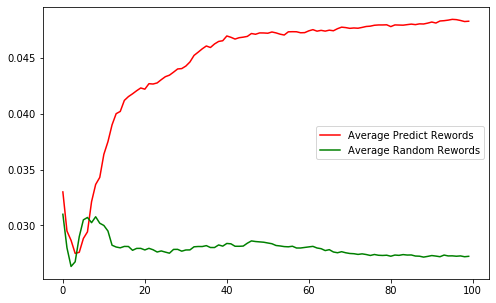

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(predict_rewords, color='r', label='Average Predict Rewords')
plt.plot(random_rewords, color='g', label='Average Random Rewords')
plt.legend()